**TASK**

"You've been asked to help the marketing team in increasing performance of their marketing campaign. The team wants to leverage Advanced Analytics to improve campaign targeting. In other words they want to identify customers for which the gain from being contacted is the highest. To establish a proof of concept they provided data from previous campaign for both control and targeted groups, which were selected at random from non-users before the campaign start. Aim of the campaign was to persuade customers to subscribe to the term deposit. The product (term deposit) was available also to the control group (but not marketed).

Assuming the total campaign budget is fixed calculate expected lift from using model predictions vs random selection (as done before).

We would like you to leverage relevant analytical methods to develop proof of concept for the next wave of the campaign (same message) and it's expected lift. "

**DATASET**

The dataset contains information about direct marketing campaign (phone calls) of a Portuguese banking institution.

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [23]:
#importing packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import xgboost as xgb 
import warnings
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

from IPython.display import display
import statsmodels.api as sm

from random import shuffle
from random import randint
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from operator import itemgetter
import time
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

import gc

xgb.set_config(verbosity=0)

In [24]:
#data
df = pd.read_csv('bank_data_prediction_task.csv', low_memory=False).rename(columns = {'emp.var.rate':'emp_var_rate','cons.price.idx':'cons_price_idx',
                         'cons.conf.idx':'cons_conf_idx', 'nr.employed':'nr_employed'})

df.head()

,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,month,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,test_control_flag
0,1,37,services,married,high.school,no,yes,no,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
1,2,56,services,married,high.school,no,no,yes,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
2,3,41,blue-collar,married,unknown,unknown,no,no,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes,campaign group
3,4,25,services,single,high.school,no,yes,no,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
4,5,25,services,single,high.school,no,yes,no,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group


In [25]:
df.pop('Unnamed: 0')

0            1
1            2
2            3
3            4
4            5
         ...  
41183    41184
41184    41185
41185    41186
41186    41187
41187    41188
Name: Unnamed: 0, Length: 41188, dtype: int64

In [26]:
df.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,41188.00000,16476.000000,16476.000000,41188.000000,41188.000000,41188.000000,40938.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,259.660172,2.546856,962.475454,0.172963,0.081886,93.575950,-40.502600,3.621291,5167.035911
std,10.42125,260.660561,2.699664,186.910907,0.494901,1.570960,0.578889,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,321.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


(array([16476.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 24712.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

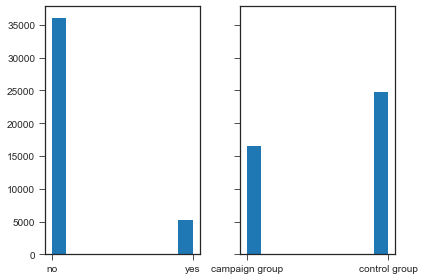

In [27]:
#targets
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(df.y, bins=10)
axs[1].hist(df.test_control_flag, bins=10)

In [28]:
df['pdays'].value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

In [68]:
#transformation for dychotomic variable
df['pdays'] = df['pdays'].replace(999, 'yes')
for i in df.pdays:
    if type(i) == int:
        df['pdays'] = df['pdays'].replace(i, 'no')

In [69]:
df.pdays.value_counts()

yes    39673
no      1515
Name: pdays, dtype: int64

In [31]:
df.isnull().sum()/len(df)

age                  0.000000
job                  0.000000
marital              0.000000
education            0.000000
default              0.000000
housing              0.000000
loan                 0.000000
contact              0.599981
month                0.599981
day_of_week          0.599981
duration             0.599981
campaign             0.599981
pdays                0.000000
previous             0.000000
poutcome             0.000000
emp_var_rate         0.000000
cons_price_idx       0.006070
cons_conf_idx        0.000000
euribor3m            0.000000
nr_employed          0.000000
y                    0.000000
test_control_flag    0.000000
dtype: float64

XGBOOST!!!

 XGBoost, because it's working with missing values AND HAS A LOT OF OTHER ADVENTAGES

In [71]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y', 'test_control_flag'],
      dtype='object')

In [72]:
target = 'y'
numFeatures = ['age', 'duration', 'campaign','previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
catFeatures = ['pdays', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'test_control_flag']

In [73]:
#ENCODING
df_prim = df.copy()
mapy = {}
for feature in catFeatures:
    le = preprocessing.LabelEncoder()
    df_prim[feature] = le.fit_transform(df[feature])
    mapy[feature] = le

In [74]:
features = df_prim.columns.tolist()


features.remove(target)
print(features)

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'test_control_flag']


In [75]:
df_prim[target] = (df_prim[target]=="yes").astype(int)


In [76]:

#wrapper
def run_xgb(train, test, features, target,
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparams
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparams
            rate_drop = 0.2, skip_drop=0.5, # hiperparams
            num_boost_round = 1000, early_stopping_rounds = 40, # hiperparams
            debug=True, eval_metric= ["auc"], objective = "binary:logistic", # konfiguracja
            seed=2019, booster = "gbtree", tree_method="exact", grow_policy="depthwise"):
  

   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    

    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length test:', len(test.index))


    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    params["lambda"]=lambdaX
    

    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dtest = xgb.DMatrix(test[features].values, test[target].values, feature_names=test[features].columns.values)

    evals = [(dtrain, 'train'), (dtest, 'test')]
    
    train_history = dict()

    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    score = gbm.best_score

    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dtest, ntree_limit=gbm.best_iteration)

    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('TIME: {} min'.format(round((time.time() - start_time)/60, 2)))
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

RANDOM SEARCH

In [77]:
X_train, X_test = train_test_split(df_prim, test_size=0.3, random_state=2019, stratify=df_prim[target].values)


In [ ]:
#ALL VARIABLES

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 40, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed 2019, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 28831
Length test: 12357
[0]	train-auc:0.77127	test-auc:0.76452
[1]	train-auc:0.78103	test-auc:0.77282
[2]	train-auc:0.80527	test-auc:0.79323
[3]	train-auc:0.81196	test-auc:0.79798
[4]	train-auc:0.81506	test-auc:0.80084
[5]	train-auc:0.81499	test-auc:0.80073
[6]	train-auc:0.81384	test-auc:0.79913
[7]	train-auc:0.81515	test-auc:0.80140
[8]	train-auc:0.81778	test-auc:0.80396
[9]	train-auc:0.81797	test-auc:0.80417
[10]	train-auc:0.81900	test-auc:0.80478
[11]	train-auc:0.81994	test-auc:0.80558
[12]	train-auc:0.81810	test-auc:0.80396
[13]	train-auc:0.81858	test-auc:0.80395
[14]	train-auc:0.81870	test-auc:0.80381
[15]	train-auc:0.81891	test-auc:0.80375
[16]	

[194]	train-auc:0.87446	test-auc:0.81652
[195]	train-auc:0.87495	test-auc:0.81645
[196]	train-auc:0.87519	test-auc:0.81653
[197]	train-auc:0.87533	test-auc:0.81659
[198]	train-auc:0.87546	test-auc:0.81660


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


TIME: 0.18 min


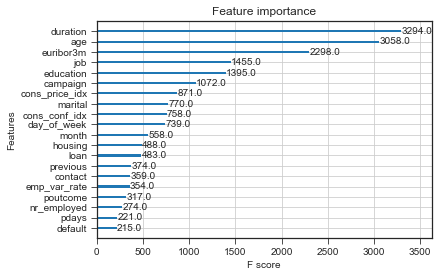

In [78]:
score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_test, features, target, early_stopping_rounds=40)

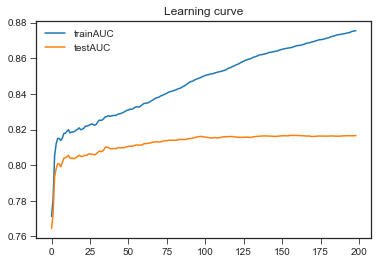

In [39]:
train_history.plot()
plt.title('Learning curve')
plt.show()

FIRSTLY I DID LOGISTIC REGRESSION AND CORRELATION, THEN I REJECTED VARIABLES

In [ ]:
#REJECTING VARIABLES
df_prim.pop('contact')
df_prim.pop('month')
df_prim.pop('day_of_week')
df_prim.pop('emp_var_rate')
df_prim.pop('nr_employed')

In [150]:
#REJECTING FROM FEATURES
features.remove('contact')
features.remove('month')
features.remove('day_of_week')
features.remove('emp_var_rate')
features.remove('nr_employed')

In [151]:
X_train, X_test = train_test_split(df_prim, test_size=0.3, random_state=2019, stratify=df_prim[target].values)


CROSS VALIDATION

In [152]:

def CVTestXGB(nFolds = 5, randomState=2020, features=features, debug=False, *args, **kwargs):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    hists = []
    fold = 1
    
    for train, test in kf.split(df_prim.index.values):
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df_prim.iloc[train], df_prim.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)
        predictions.append(testPred.tolist().copy())
        indices.append(df_prim.iloc[test].index.tolist().copy())
        trainScore = roc_auc_score(df_prim[target].iloc[train], trainPred)
        testScore = roc_auc_score(df_prim[target].iloc[test], testPred)        
        trainResults.append(trainScore)
        testResults.append(testScore)        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Test AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [153]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparams
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, debug=False)
np.mean(trainResults), np.mean(testResults)

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


(0.8567242661701719, 0.8167675659938769)

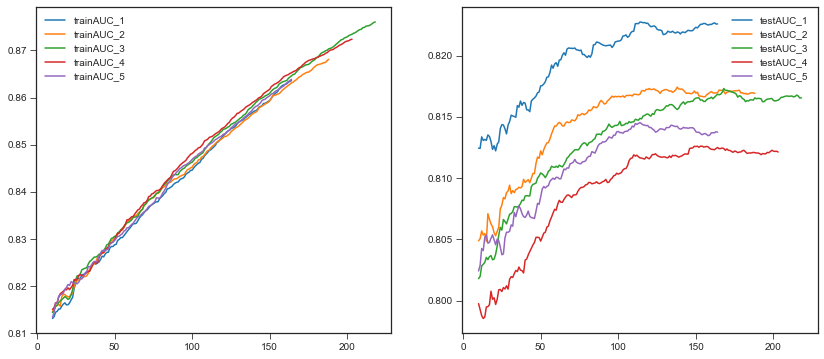

In [154]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
for x in range(1,6):
    hists[['trainAUC'+'_'+str(x)]].iloc[10:].plot(ax=ax[0])
    hists[['testAUC'+'_'+str(x)]].iloc[10:].plot(ax=ax[1])
plt.show()

In [155]:
resList = []
for k in range(10):
    trainResults, testResults, predictions, indices, hists = CVTestXGB(randomState=randint(1,10000),
        max_depth=6, lambdaX=1, subsample=0.8, colsample_bytree=0.6, gamma=0.01, debug=False)
    resList.append(np.mean(testResults))
    print(np.mean(testResults), testResults)

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8175973238663751 [0.8093228013106416, 0.8316567681161902, 0.8188550355925132, 0.8163194795303185, 0.8118325347822125]


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8182693108127459 [0.8214374247983246, 0.8204580434782904, 0.80920563688559, 0.8179797805709644, 0.8222656683305601]


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8170314797601176 [0.8272517903689752, 0.814485501429669, 0.8103678612179871, 0.8237717052754785, 0.8092805405084786]


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.817551265643538 [0.8227791036539318, 0.8134154891886106, 0.80621363424908, 0.8206197460726922, 0.8247283550533758]


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8169740092609183 [0.8070469937165603, 0.8224028286208748, 0.8207998350723511, 0.8231767658465812, 0.8114436230482244]


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8178551846658682 [0.81996151498994, 0.8186374217188089, 0.8171443646401391, 0.8159830890505587, 0.8175495329298942]


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8188072477463235 [0.8193336558119158, 0.8193092433699165, 0.8199995294456317, 0.8200354363629926, 0.8153583737411613]


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8167578294325686 [0.8193071340139502, 0.8324654828053487, 0.8238087192626953, 0.8019000379443552, 0.8063077731364934]


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8172760603714215 [0.8181325195061373, 0.8196657576581219, 0.8102651228891851, 0.8278631403399146, 0.8104537614637487]


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8179572273704176 [0.8236764477819934, 0.8052804842416666, 0.8124190470560291, 0.8302963497578052, 0.8181138080145934]


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [156]:
print([round(x, 3) for x in resList])
print(np.mean(resList))

[0.818, 0.818, 0.817, 0.818, 0.817, 0.818, 0.819, 0.817, 0.817, 0.818]
0.8176076938930293


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.8153049362939381


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 0.816683067426158


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 0.8172168683371284


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 0.8167675659938769


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 0.8166648025118507


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 0.8158948228646844


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


10 0.81448080118956


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


11 0.8137934314596663


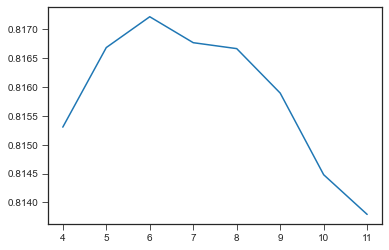

In [157]:
rang = range(4,12)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 0.8135412857853777


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


3 0.8153632873714848


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.8168382062395256


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 0.8171549875835333


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 0.8167727007460274


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 0.8172168683371284


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 0.8166254888463321


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 0.8167853924984587


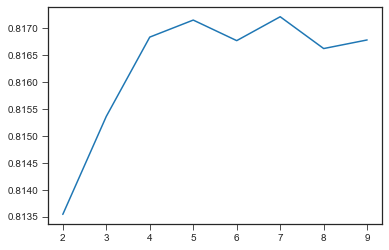

In [158]:
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=6, subsample = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 0.8113673594113451


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


3 0.813846917930312


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.8158495689418945


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 0.8165601215788278


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 0.8165952854094296


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 0.8172168683371284


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 0.8171770775823047


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 0.8168782313153846


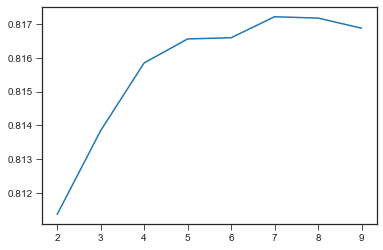

In [159]:
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=6, subsample = 0.7, colsample_bytree = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0 0.8169540168676257


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 0.8172168683371284


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.8170522341215273


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 0.8173144131423358


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


16 0.816762920253824


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


25 0.8163474224089897


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


36 0.8161227632046255


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


49 0.8158499336391827


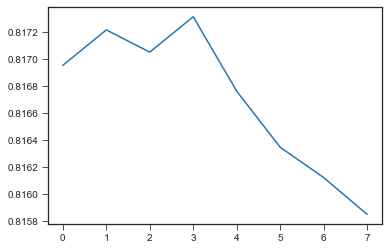

In [160]:
rang = range(0,8)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=6, subsample = 0.7, colsample_bytree = 0.7, lambdaX=x**2)
    print(x**2, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.01 0.8169845210659863


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.1 0.8170598503192468


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.5 0.8173154684377562


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 0.8174111578112406


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 0.8170203155033994


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.8174176082305818


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 0.8164734561080623


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 0.8155297341061918


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


10 0.8139737666810449


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


15 0.812001051647161


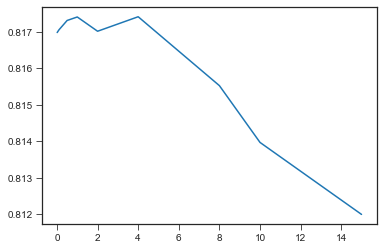

In [163]:
rang = [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 15]
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=6, subsample = 0.7, colsample_bytree = 0.7, lambdaX=9, gamma=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

MODEL XGB - BEST PARAMS

In [164]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=6, subsample = 0.7, colsample_bytree = 0.7, lambdaX=9, gamma=4)
print(np.mean(testResults))


modelXGB = {
    "name":"XGB",
    "specification":'max_depth=6, subsample = 0.7, colsample_bytree = 0.7, lambdaX=9, gamma=4)',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8174176082305818


C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


LIFT

In [165]:
true_xgb = df_prim[target].sort_index()
pred_xgb = pd.Series(sum(modelXGB["predictions"], []), index=sum(modelXGB["indices"], [])).sort_index()


fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(true_xgb, pred_xgb)
roc_auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)

In [166]:
#LIFT!!!!!!!!!!!!!
df_prim['pred_xgb'] = pred_xgb
lift = df_prim[['pred_xgb', 'test_control_flag', 'y']].sort_values(by='pred_xgb', ascending=False)
lift['camp'] = lift.test_control_flag.replace(0, 'yes').replace(1, 'no')
lift['camp'] = (lift['camp']=="yes").astype(int)


In [179]:
lift.loc[lift['camp'] == 1]['y'].value_counts()

0    13992
1     2484
Name: y, dtype: int64

In [184]:
lift[:16476]['y'].value_counts()

0    12359
1     4117
Name: y, dtype: int64

ROC AND PRECISION-RECALL

In [167]:
fpr_los, tpr_los, thresholds_los = metrics.roc_curve(lift.camp, lift.pred_xgb)
roc_auc_los = metrics.auc(fpr_los, tpr_los)

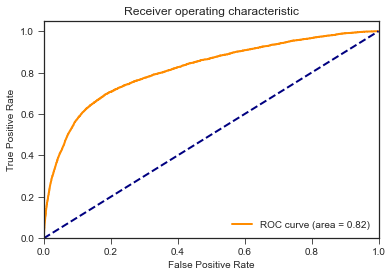

In [168]:
plt.figure()
lw = 2
plt.plot(
    fpr_xgb,
    tpr_xgb,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_xgb,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

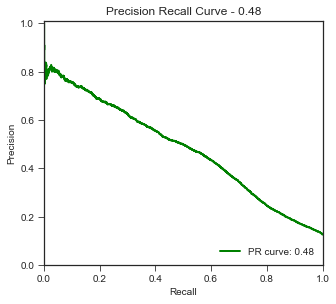

In [169]:

precision, recall, thresholds = precision_recall_curve(true_xgb, pred_xgb)

average_precision = average_precision_score(true_xgb, pred_xgb)
average_precision = round(average_precision, 2)

fig, ax = plt.subplots(figsize=(5,4.5))


lw = 2


ax.plot(recall, precision, color='g', lw=lw, label=f'PR curve: {average_precision}')


ax.set_xlim([0, 1])
ax.set_ylim([0.0, 1.01])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title(f'Precision Recall Curve - {average_precision}')
ax.legend(loc="lower right")
plt.show()

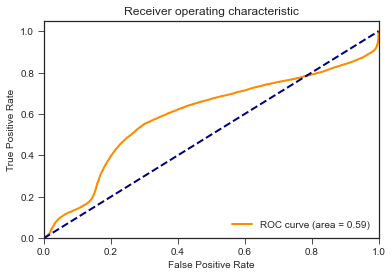

In [758]:
plt.figure()
lw = 2
plt.plot(
    fpr_los,
    tpr_los,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_los,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

LOGISTIC REGRESSION WHICH I DID BEFORE XGBOOST

In [506]:
df_bis = df.copy()
df_bis

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,test_control_flag
0,37,services,married,high.school,no,yes,no,telephone,may,mon,...,yes,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
1,56,services,married,high.school,no,no,yes,telephone,may,mon,...,yes,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
2,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,yes,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes,campaign group
3,25,services,single,high.school,no,yes,no,telephone,may,mon,...,yes,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
4,25,services,single,high.school,no,yes,no,telephone,may,mon,...,yes,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,29,unemployed,single,basic.4y,no,yes,no,NaN,NaN,NaN,...,no,1,success,-1.1,94.767,-50.8,1.028,4963.6,no,control group
41184,46,blue-collar,married,professional.course,no,no,no,NaN,NaN,NaN,...,yes,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,control group
41185,56,retired,married,university.degree,no,yes,no,NaN,NaN,NaN,...,yes,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,control group
41186,44,technician,married,professional.course,no,no,no,NaN,NaN,NaN,...,yes,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,control group


NAN filling

In [617]:
df_bis = df.copy()
df_bis['day_of_week'] = df_bis['day_of_week'].replace(np.NaN, 'Unknown')
df_bis['month'] = df_bis['month'].replace(np.NaN, 'Unknown')
df_bis['contact'] = df_bis['contact'].replace(np.NaN, 'Unknown')

In [619]:
#ENCODING
df_prim2 = df_bis.copy()
from sklearn import preprocessing

mapy2 = {}
for feature in catFeatures:
    le2 = preprocessing.LabelEncoder()
    df_prim2[feature] = le2.fit_transform(df_bis[feature])
    mapy2[feature] = le2

In [621]:
#IMPUTING BY MEDIAN
df_prim2[target] = (df_prim2[target]=="yes").astype(int)
df_prim2['campaign'] = df_prim2['campaign'].fillna(df_prim2['campaign'].median())
df_prim2['duration'] = df_prim2['duration'].fillna(df_prim2['duration'].median())
 
df_prim2['cons_price_idx'] = df_prim2['duration'].fillna(df_prim2['duration'].median())
print(df_prim2)

       age  job  marital  education  default  housing  loan  contact  month  \
0       37    7        1          3        0        2     0        2      7   
1       56    7        1          3        0        0     2        2      7   
2       41    1        1          7        1        0     0        2      7   
3       25    7        2          3        0        2     0        2      7   
4       25    7        2          3        0        2     0        2      7   
...    ...  ...      ...        ...      ...      ...   ...      ...    ...   
41183   29   10        2          0        0        2     0        0      0   
41184   46    1        1          5        0        0     0        0      0   
41185   56    5        1          6        0        2     0        0      0   
41186   44    9        1          5        0        0     0        0      0   
41187   74    5        1          5        0        2     0        0      0   

       day_of_week  ...  pdays  previous  poutcome 

In [624]:
"+".join(features)

'age+job+marital+education+default+housing+loan+contact+month+day_of_week+duration+campaign+pdays+previous+poutcome+emp_var_rate+cons_price_idx+cons_conf_idx+euribor3m+nr_employed+test_control_flag'

In [767]:
mod = sm.GLM.from_formula(formula="y ~ test_control_flag+age+job+marital+education+default+housing+loan+contact+month+day_of_week+duration+campaign+pdays+previous+poutcome+emp_var_rate+cons_price_idx+cons_conf_idx+euribor3m+nr_employed",
                            data=df_prim2, family=sm.families.Binomial())
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                41188
Model:                            GLM   Df Residuals:                    41167
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12661.
Date:                Mon, 04 Apr 2022   Deviance:                       25323.
Time:                        05:28:11   Pearson chi2:                 1.57e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            58.2445      3.893     14.961      0.000      50.614      65.875
test_control_flag    -0.4011      0.107     -3.756      0.000      -0.610      -0.192
age                   0.0072      0.002      4.484      0.000       0.004       0.010
job                   0.0070      0.005      1.511      0.131      -0.002       0.016
marital               0.2908      0.030      9.590      0.000       0.231       0.350
education             0.0064      0.008      0.796      0.426      -0.009       0.022
default              -0.2875      0.051     -5.689      0.000      -0.387      -0.188
housing              -0.0856      0.017     -5.083      0.000      -0.119      -0.053
loan                 -0.0658      0.024     -2.780      0.005      -0.112      -0.019
contact              -0.0365      0.061     -0.600      0.549      -0.156       0.083
month                -0.0674      0.011     -6.363      0.000      -0.088      -0.047
day_of_week           0.0196      0.018      1.090      0.276      -0.016       0.055
duration              0.0015   4.33e-05     33.986      0.000       0.001       0.002
campaign              0.0028      0.011      0.249      0.803      -0.019       0.025
pdays                -0.8915      0.144     -6.204      0.000      -1.173      -0.610
previous              0.0289      0.051      0.564      0.573      -0.071       0.129
poutcome              0.3720      0.069      5.407      0.000       0.237       0.507
emp_var_rate         -0.2893      0.048     -5.976      0.000      -0.384      -0.194
cons_price_idx        0.0015   4.33e-05     33.986      0.000       0.001       0.002
cons_conf_idx         0.0017      0.004      0.380      0.704      -0.007       0.010
euribor3m             0.3470      0.069      5.038      0.000       0.212       0.482
nr_employed          -0.0120      0.001    -14.914      0.000      -0.014      -0.010
=====================================================================================
"""

In [683]:
probs = res.predict()
probs

array([0.06889303, 0.10080009, 0.06101364, ..., 0.38270986, 0.40802463,
       0.33234704])

In [685]:
fpr_log, tpr_log, thresholds_log = metrics.roc_curve(df_prim2.y, probs)
roc_auc_log = metrics.auc(fpr_log, tpr_log)

LOGISTIC REGRESSION FOR ALL SAMPLE ROC CURVE

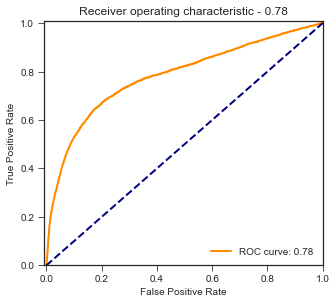

In [686]:
rocScore = roc_auc_score(df_prim2.y, probs)
rocScore = round(rocScore, 2)

fig, ax = plt.subplots(figsize=(5,4.5))


lw = 2

ax.plot(fpr_log, tpr_log, color='darkorange', lw=lw, label=f'ROC curve: {rocScore}')

ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

ax.set_xlim([-0.01, 1.0])
ax.set_ylim([0.0, 1.01])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'Receiver operating characteristic - {rocScore}')
ax.legend(loc="lower right")
plt.show()

In [687]:
probs = res.predict()
cutoff = 0.5
preds = np.array([1 if x<cutoff else 0 for x in probs])

In [688]:
#CONFUSION MARIX WITH RANDOM CUT OFF (arbitralnie ustawiłam na 0.5)
display(pd.crosstab(df.y, preds))
display(pd.crosstab(df.y, preds, normalize=True).round(3))
display(pd.crosstab(df.y, preds, normalize=True, margins=True).round(3))

col_0,0,1
y,,
no,592,35428
yes,1090,4078


col_0,0,1
y,,
no,0.014,0.860
yes,0.026,0.099


col_0,0,1,All
y,,,
no,0.014,0.860,0.875
yes,0.026,0.099,0.125
All,0.041,0.959,1.000


CORRELATION WHICH I DID BEFORE XGBOOST TO REJECT HIGHY CORRELATED VARIABLES

In [192]:
corr = df_prim.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\User\AppData\Local\Temp/ipykernel_4896/4248721851.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,age,job,marital,education,default,housing,loan,duration,campaign,pdays,previous,poutcome,cons_price_idx,cons_conf_idx,euribor3m,y,test_control_flag,pred_xgb
age,1.00,0.00,-0.39,-0.12,0.16,-0.00,-0.01,-0.01,0.01,-0.03,0.02,0.02,0.00,0.13,0.01,0.02,0.00,0.04
job,0.00,1.00,0.03,0.13,-0.03,0.01,-0.01,-0.01,-0.01,-0.03,0.02,0.01,-0.02,0.05,-0.01,0.02,0.00,0.05
marital,-0.39,0.03,1.00,0.11,-0.08,0.01,0.01,0.01,-0.01,-0.04,0.04,0.00,-0.06,-0.03,-0.09,0.07,0.00,0.14
education,-0.12,0.13,0.11,1.00,-0.19,0.02,0.01,-0.01,0.02,-0.05,0.04,0.02,-0.08,0.08,-0.04,0.04,0.00,0.08
default,0.16,-0.03,-0.08,-0.19,1.00,-0.02,-0.00,-0.02,0.02,0.08,-0.10,0.02,0.17,0.03,0.20,-0.09,0.00,-0.18
housing,-0.00,0.01,0.01,0.02,-0.02,1.00,0.04,0.00,-0.01,-0.01,0.02,-0.01,-0.08,-0.03,-0.06,-0.01,-0.01,-0.02
loan,-0.01,-0.01,0.01,0.01,-0.00,0.04,1.00,-0.01,0.01,0.00,-0.00,-0.00,-0.00,-0.01,0.00,-0.02,0.01,-0.03
duration,-0.01,-0.01,0.01,-0.01,-0.02,0.00,-0.01,1.00,-0.07,-0.06,0.02,0.03,0.00,-0.01,-0.03,0.32,nan,0.65
campaign,0.01,-0.01,-0.01,0.02,0.02,-0.01,0.01,-0.07,1.00,0.05,-0.08,0.03,0.13,-0.01,0.14,-0.05,nan,-0.10
pdays,-0.03,-0.03,-0.04,-0.05,0.08,-0.01,0.00,-0.06,0.05,1.00,-0.59,-0.48,0.08,-0.09,0.30,-0.28,-0.00,-0.57
